## Imoport libraries

In [37]:
import numpy as np
import cv2 as cv
import os
import copy
import matplotlib.pyplot as plt
import pandas as pd

## Pre process and Iou Function

In [40]:
%%time
traffic_sign_imgs = []
traffic_annot = {}
filename = []
columns = 10
rows = 7

# load image from folder 
path = 'C:/Users/JianRu Thiang/Desktop/UTAR CS Y3S1/Mini Project Image Processing/mini project report 2/image'
for file in os.listdir(path):
    img_traffic_sign = cv.imread(os.path.join(path,file))
    traffic_sign = cv.cvtColor(img_traffic_sign, cv.COLOR_BGR2RGB)
    traffic_sign_imgs.append(traffic_sign)
    filename.append(file)
        
traffic_sign = np.array(traffic_sign_imgs, dtype=object)

# load all the annotations given from the txt, annotation as ground image
with open("TsignRecgTrain4170Annotation.txt") as annotations:
    for content in annotations:
        traffic_sign_imgs_name = content.split(';')
        dict_key = traffic_sign_imgs_name[0]
        for i in range(1,8): traffic_sign_imgs_name[i] = int(traffic_sign_imgs_name[i])
        traffic_annot[dict_key] = traffic_sign_imgs_name[1:8]

# calculate IOU
def annotation(pred_coor):
    ori_area = []
    iou_result = []
    ori = copy.deepcopy(traffic_sign)
    i = 0
    for coo in filename:
        coorx1 = traffic_annot[coo][2]
        coory1 = traffic_annot[coo][3]
        coorx2 = traffic_annot[coo][4]
        coory2 = traffic_annot[coo][5]
        cv.rectangle(ori[i],(coorx1,coory1),(coorx2,coory2),(0,255,0),2, cv.LINE_AA)
    
        ix1 = np.maximum(traffic_annot[coo][2], pred_coor[i][1])
        iy1 = np.maximum(traffic_annot[coo][3], pred_coor[i][2])
        ix2 = np.minimum(traffic_annot[coo][4], pred_coor[i][3])
        iy2 = np.minimum(traffic_annot[coo][5], pred_coor[i][4])
           
     
        
        # Intersection height and width.
        i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
        i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))

        area_of_intersection = i_height * i_width

        # Ground Truth dimensions.
        gt_height = traffic_annot[coo][5] - traffic_annot[coo][3] + 1
        gt_width = traffic_annot[coo][4] - traffic_annot[coo][2] + 1

        # Prediction dimensions.
        pd_height = pred_coor[i][4] - pred_coor[i][2] + 1
        pd_width = pred_coor[i][3] - pred_coor[i][1] + 1
        
        
        area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection

        iou = area_of_intersection / area_of_union
        iou_result.append(iou)
        i+=1
    df = pd.DataFrame(np.round(iou_result,4), columns=["IOU"])
    return df

CPU times: total: 62.5 ms
Wall time: 62 ms


## Segment with Contour

In [ ]:
def Contour(img):
    # define kernel for sharpening
    kernel = np.zeros((3,3), dtype = np.uint8)
    kernel[1,1] = 1
    
    for i in range(rows*columns):
        img_copy = img.copy()

        blurring_kernel = np.ones((3,3))/9.0
        sharpen_kernel = 2*kernel - blurring_kernel
        res = cv.filter2D(img_copy[i], -1, sharpen_kernel)
        
        # smooth the images
        blur = cv.GaussianBlur(res,(5,5),0)
        # chagne the image to grayscale
        gray = cv.cvtColor(blur, cv.COLOR_RGB2GRAY)
        
        # declare a threshold value for canny 
        threshold = 60

        canny = cv.Canny(gray, threshold, 2*threshold, 7)

        contours, hierarchy = cv.findContours(canny.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        object_perimeter = []

        for cnt in contours:
            perimeter = cv.arcLength(cnt, False)
            object_perimeter.append(perimeter)
       
        max_idx = np.argmax(object_perimeter)

        traffic_sign = contours[max_idx]
        cv.drawContours(img_copy[i], [traffic_sign], -1, (0, 255, 0), 2, cv.LINE_AA)        
        
        
    fig = plt.figure(figsize=(12, 12))
    for i in range(rows*columns):
        fig.add_subplot(rows,columns, i+1)
        plt.imshow(img_copy[i])
        plt.axis('off')
    plt.show()

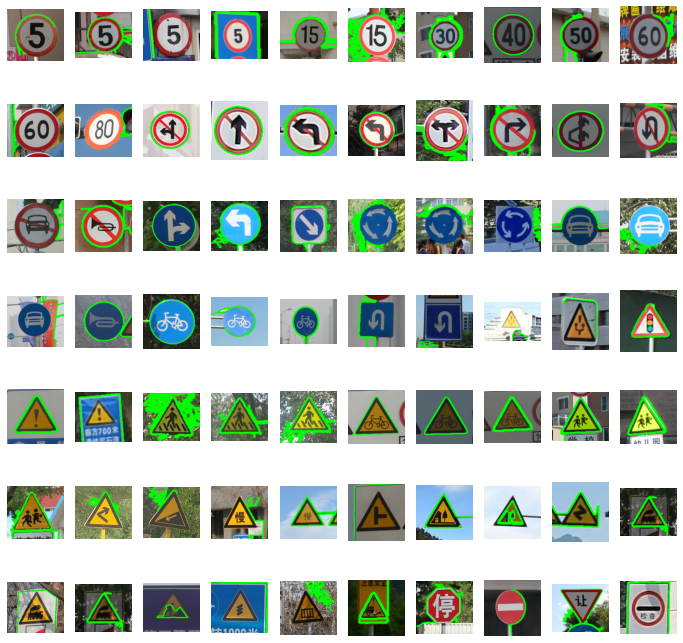

In [7]:
testset = copy.deepcopy(traffic_sign)
Contour(testset)

## Segment with Contour and applying threshold

In [27]:
def contourwithThreshold(image):
    columns = 10
    rows = 7

    kernel = np.zeros((3,3), dtype = np.uint8)
    kernel[1,1] = 1
  
    
    for i in range(rows*columns):
        image_copy = image.copy()
        blurring_kernel = np.ones((3,3))/9.0
        sharpen_kernel = 2*kernel - blurring_kernel
        res = cv.filter2D(image_copy[i], -1, sharpen_kernel)
        
        # smooth the images
        blur = cv.GaussianBlur(res,(5,5),0)
        # chagne the image to grayscale
        gray = cv.cvtColor(blur, cv.COLOR_RGB2GRAY)
        _, th = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

        
        threshold = 30

        canny = cv.Canny(th, threshold, 2*threshold, L2gradient=True)

        contours, hierarchy = cv.findContours(canny.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        perimeter = []

        for cnt in contours:
            prt = cv.arcLength(cnt, True)
            perimeter.append(prt)
       
        # find the highest perimeter of each images 
        max_idx = np.argmax(perimeter)

        traffic_sign = contours[max_idx]
        # drwa contour
        cv.drawContours(image_copy[i], [traffic_sign], -1, (0, 255, 0), 2, cv.LINE_AA)        
        
        
    fig = plt.figure(figsize=(12, 12))
    for i in range(rows*columns):
        fig.add_subplot(rows,columns, i+1)
        plt.imshow(image[i])
        plt.axis('off')
    plt.show()

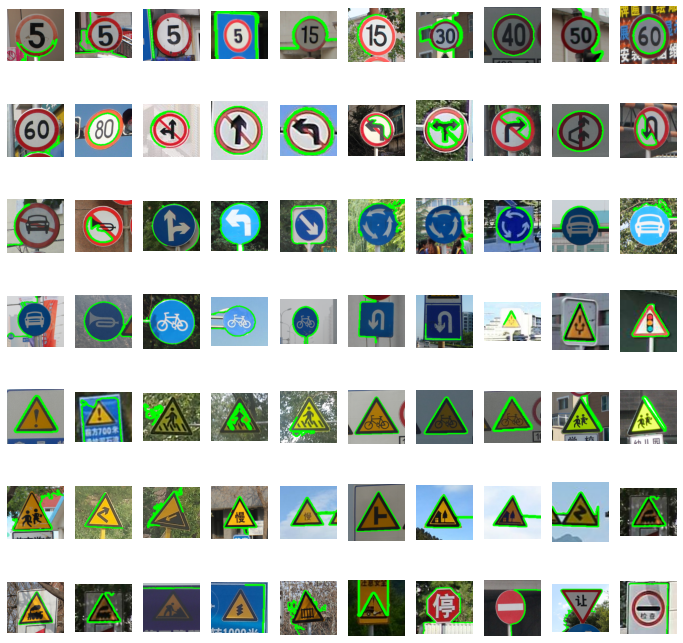

In [28]:
testset2 = copy.deepcopy(traffic_sign)
contourwithThreshold(testset2)

## Segment with the Area

In [29]:
def contourwithArea(image):
    coord_contourwithArea = []

    columns = 10
    rows = 7
    kernel = np.zeros((3,3), dtype = np.uint8)
    kernel[1,1] = 1

    
    image_copy = copy.deepcopy(image)
    
    for i in range(rows*columns):
        blurring_kernel = np.ones((3,3))/9.0
        sharpen_kernel = 2*kernel - blurring_kernel
        res = cv.filter2D(image_copy[i], -1, sharpen_kernel)
        
        blur = cv.GaussianBlur(res,(5,5),0)
        gray = cv.cvtColor(blur, cv.COLOR_RGB2GRAY)
                                
        _, th = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

        
        threshold = 60

        canny = cv.Canny(th, threshold, 2*threshold, L2gradient=True)
        
        contours, hierarchy = cv.findContours(canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        cv.drawContours(image_copy[i], contours, -1, (0, 255, 0), 1, cv.LINE_AA)        

        object_area = []
        for cnt in contours:
            area = cv.contourArea(cnt)
            object_area.append(area)
       # find the highest area from each images
        max_idx = np.argmax(object_area)
        cnt_sign = contours[max_idx]

        x,y,w,h = cv.boundingRect(cnt_sign)
        
        # Draw the rectangle 
        cv.rectangle(image[i],(x,y),(x+w,y+h),(0,255,0),2, cv.LINE_AA)
        # save the coordinate from the rectangle into a list 
        coord_contourwithArea.append([i,x,y,x+w,y+h])
    # convert it to np array
    coord_contourwithArea = np.array(coord_contourwithArea)
    # pass the list to the iou function to calculate iou
    iou = annotation(coord_contourwithArea)
        
    fig = plt.figure(figsize=(12, 12))
    for i in range(rows*columns):
        fig.add_subplot(rows,columns, i+1)
        plt.imshow(image[i])
        # show the percentage of iou
        plt.title(iou["IOU"][i])
        plt.axis('off')
    plt.show()
    

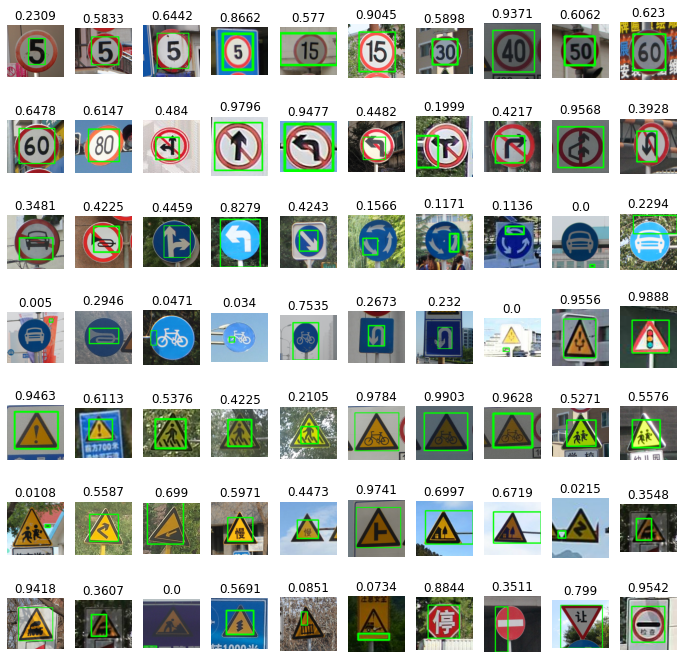

In [30]:
testset3 = copy.deepcopy(traffic_sign)
contourwithArea(testset3)


## Segment with the Perimeter

In [17]:
def contourwithPerimeter(image):
    coord_contourwithPerimeter = []
    
    columns = 10
    rows = 7
    kernel = np.zeros((3,3), dtype = np.uint8)
    kernel[1,1] = 1
  
    image_copy = copy.deepcopy(image)
    for i in range(rows*columns):
        blurring_kernel = np.ones((3,3))/9.0
        sharpen_kernel = 2*kernel - blurring_kernel
        res = cv.filter2D(image_copy[i], -1, sharpen_kernel)
        
        blur = cv.GaussianBlur(res,(5,5),0)
        gray = cv.cvtColor(blur, cv.COLOR_RGB2GRAY)
        _, th = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

        
        threshold = 30

        canny = cv.Canny(th, threshold, 2*threshold, L2gradient=True)
        
        contours, hierarchy = cv.findContours(canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        cv.drawContours(image_copy[i], contours, -1, (0, 255, 0), 1, cv.LINE_AA)        
        
        object_perimeter = []
        for cnt in contours:
            perimeter = cv.arcLength(cnt, True)
            object_perimeter.append(perimeter)
        max_idx = np.argmax(object_perimeter)
        cnt_sign = contours[max_idx]


        x,y,w,h = cv.boundingRect(cnt_sign)
        # Draw the rectangle
        cv.rectangle(image[i],(x,y),(x+w,y+h),(0,255,0),2, cv.LINE_AA)
        coord_contourwithPerimeter.append([i,x,y,x+w,y+h])
    
    coord_contourwithPerimeter = np.array(coord_contourwithPerimeter)
    iou = annotation(coord_contourwithPerimeter)
    
    
    fig = plt.figure(figsize=(12, 12))
    for i in range(rows*columns):
        fig.add_subplot(rows,columns, i+1)
        plt.imshow(image[i])
        plt.title(iou["IOU"][i])
        plt.axis('off')
    plt.show()

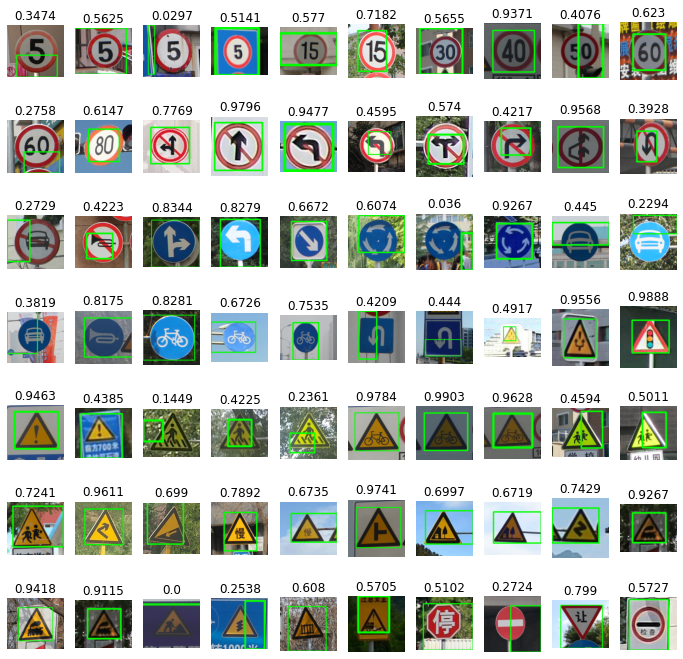

In [18]:
testset4 = copy.deepcopy(traffic_sign)
contourwithPerimeter(testset4)

## Segment with RGB color

In [20]:
def kMeanRGB(img):
    coord_kMeanRGN = []
    columns = 10
    rows = 7 
    threshold = 30
    
    image_copy = copy.deepcopy(img)
    for i in range(rows*columns):
        img_reshape = image_copy[i].reshape((-1,3))
        img_reshape = np.float32(img_reshape)


        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        K = 7 # let the clusters be 7 
        attempts = 10
        ret,label, center = cv.kmeans(img_reshape,K, None, criteria, attempts, cv.KMEANS_RANDOM_CENTERS)

        # center
        center = np.uint8(center)

        res = center[label.ravel()]
        res_img = res.reshape(image_copy[i].shape)


        from numpy import linalg as LN
        # create color masks based on RGB color space
        white = (224,224,224)
        black = (32,32,32)
        low_blue = (51,153,255)
        low_yellow = (225,204,51)
        low_red = (160,68,68)
        high_blue = (16,35,159)
        high_yellow = (209,149,29)
        high_red = (146,8,8)

        idx_white = np.argmin(LN.norm(white - center, axis = 1))
        idx_black = np.argmin(LN.norm(black - center, axis = 1))
        idx_lowblue = np.argmin(LN.norm(low_blue - center, axis = 1))
        idx_lowyellow = np.argmin(LN.norm(low_yellow - center, axis = 1))
        idx_lowred = np.argmin(LN.norm(low_red - center, axis = 1))
        idx_highblue = np.argmin(LN.norm(high_blue - center, axis = 1))
        idx_highyellow = np.argmin(LN.norm(high_yellow - center, axis = 1))
        idx_highred = np.argmin(LN.norm(high_red - center, axis = 1))

        mask_white = res_img == center[idx_white]
        mask_black = res_img == center[idx_black]
        mask_low_blue = res_img == center[idx_lowblue]
        mask_low_yellow = res_img == center[idx_lowyellow]
        mask_low_red = res_img == center[idx_lowred]
        mask_high_blue = res_img == center[idx_highblue]
        mask_high_yellow = res_img == center[idx_highyellow]
        mask_high_red = res_img == center[idx_highred]


        mask_combine = mask_white + mask_black + mask_low_blue 
        + mask_low_yellow + mask_low_red + mask_high_blue 
        + mask_high_yellow + mask_high_red
        seg = image_copy[i]*(mask_combine.astype("uint8"))

        blur = cv.GaussianBlur(seg,(5,5),0)

        canny = cv.Canny(blur, threshold, 2*threshold, L2gradient=True)

        contours, hierarchy = cv.findContours(canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        object_perimeter = []
        for cnt in contours:
            perimeter = cv.arcLength(cnt, True)
            object_perimeter.append(perimeter)
        max_idx = np.argmax(object_perimeter)
        cnt_sign = contours[max_idx]

        x,y,w,h = cv.boundingRect(cnt_sign)
        
        # Draw the rectangle
        cv.rectangle(image_copy[i],(x,y),(x+w,y+h),(0,255,0),2, cv.LINE_AA)
        coord_kMeanRGN.append([i,x,y,x+w,y+h])
    coord_kMeanRGN = np.array(coord_kMeanRGN)
    iou = annotation(coord_kMeanRGN)
    
    fig = plt.figure(figsize=(12, 9))
    for i in range(rows*columns):
        fig.add_subplot(rows,columns, i+1)
        plt.imshow(image_copy[i])
        plt.title(iou["IOU"][i])
        plt.axis('off')
    plt.show()

C:\Users\JianRu Thiang\AppData\Local\Temp\ipykernel_43844\339628376.py:56: DeprecationWarning: Applying '+' to a non-numerical array is ill-defined. Returning a copy, but in the future this will error.
  + mask_low_yellow + mask_low_red + mask_high_blue
C:\Users\JianRu Thiang\AppData\Local\Temp\ipykernel_43844\339628376.py:57: DeprecationWarning: Applying '+' to a non-numerical array is ill-defined. Returning a copy, but in the future this will error.
  + mask_high_yellow + mask_high_red


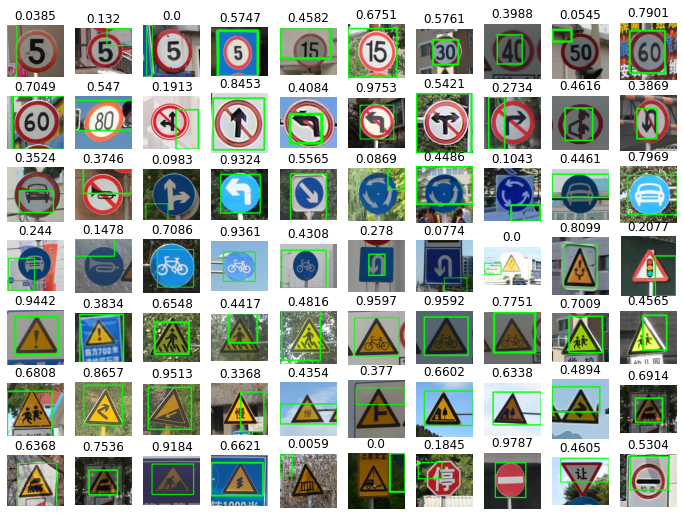

In [21]:
testset5 = copy.deepcopy(traffic_sign)
kMeanRGB(testset5)

## Segment with HSV color

In [33]:
def kMeanHSV(img):
    coord_kmeanHSV = []
    columns = 10
    rows = 7
    threshold = 30
    
    image_copy = copy.deepcopy(img)
    for i in range(rows*columns):
        img_hsv = cv.cvtColor(image_copy[i], cv.COLOR_RGB2HSV)
        img_reshape = image_copy[i].reshape((-1,3))
        img_reshape = np.float32(img_reshape)


        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        K = 7
        attempts = 10
        ret,label, center = cv.kmeans(img_reshape,K, None, criteria, attempts, cv.KMEANS_RANDOM_CENTERS)

        center = np.uint8(center)

        res = center[label.ravel()]
        res_img = res.reshape(image_copy[i].shape)


        from numpy import linalg as LN
        # create hsv color space
        white = (224,224,224)
        black = (32,32,32)
        low_blue = (51,153,255)
        low_yellow = (225,204,51)
        low_red = (160,68,68)
        high_blue = (16,35,159)
        high_yellow = (209,149,29)
        high_red = (146,8,8)

        idx_white = np.argmin(LN.norm(white - center, axis = 1))
        idx_black = np.argmin(LN.norm(black - center, axis = 1))
        idx_lowblue = np.argmin(LN.norm(low_blue - center, axis = 1))
        idx_lowyellow = np.argmin(LN.norm(low_yellow - center, axis = 1))
        idx_lowred = np.argmin(LN.norm(low_red - center, axis = 1))
        idx_highblue = np.argmin(LN.norm(high_blue - center, axis = 1))
        idx_highyellow = np.argmin(LN.norm(high_yellow - center, axis = 1))
        idx_highred = np.argmin(LN.norm(high_red - center, axis = 1))

        mask_white = res_img == center[idx_white]
        mask_black = res_img == center[idx_black]
        mask_low_blue = res_img == center[idx_lowblue]
        mask_low_yellow = res_img == center[idx_lowyellow]
        mask_low_red = res_img == center[idx_lowred]
        mask_high_blue = res_img == center[idx_highblue]
        mask_high_yellow = res_img == center[idx_highyellow]
        mask_high_red = res_img == center[idx_highred]


        mask_combine = mask_white + mask_black + mask_low_blue 
        + mask_low_yellow + mask_low_red + mask_high_blue 
        + mask_high_yellow + mask_high_red
        seg = image_copy[i]*(mask_combine.astype("uint8"))

        blur = cv.GaussianBlur(seg,(5,5),0)

        canny = cv.Canny(blur, threshold, 2*threshold, L2gradient=True)

        contours, hierarchy = cv.findContours(canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        object_perimeter = []
        for cnt in contours:
            perimeter = cv.arcLength(cnt, True)
            object_perimeter.append(perimeter)
        max_idx = np.argmax(object_perimeter)
        cnt_sign = contours[max_idx]

        x,y,w,h = cv.boundingRect(cnt_sign)
        # Draw the rectangle
        cv.rectangle(image_copy[i],(x,y),(x+w,y+h),(0,255,0),2, cv.LINE_AA)
        coord_kmeanHSV.append([i,x,y,x+w,y+h])
    coord_kmeanHSV = np.array(coord_kmeanHSV)
    iou = annotation(coord_kmeanHSV)

    
    
    fig = plt.figure(figsize=(12, 9))
    for i in range(rows*columns):
        fig.add_subplot(rows,columns, i+1)
        plt.imshow(image_copy[i])
        plt.title(iou["IOU"][i])
        plt.axis('off')
    plt.show()

C:\Users\JianRu Thiang\AppData\Local\Temp\ipykernel_43844\215692704.py:56: DeprecationWarning: Applying '+' to a non-numerical array is ill-defined. Returning a copy, but in the future this will error.
  + mask_low_yellow + mask_low_red + mask_high_blue
C:\Users\JianRu Thiang\AppData\Local\Temp\ipykernel_43844\215692704.py:57: DeprecationWarning: Applying '+' to a non-numerical array is ill-defined. Returning a copy, but in the future this will error.
  + mask_high_yellow + mask_high_red


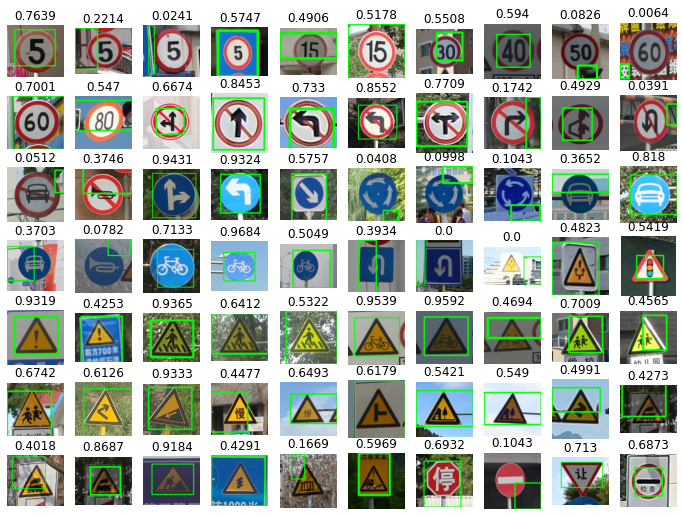

In [34]:
testset6 = copy.deepcopy(traffic_sign)
kMeanHSV(testset6)